In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

idx = pd.IndexSlice

In [2]:
fn = str(Path.cwd().parent / 'summaries' / 'total_summary_{}.csv').format('flex')

c = pd.read_csv(
    fn,
    index_col=[0,1],
    parse_dates=True
).loc[idx[:,'congestion_rent'], 'zonal']

'''
w_zonal = pd.read_csv(
    fn,
    index_col=[0,1],
    parse_dates=True
).loc[idx[:,'wholesale'], 'zonal']

w_national = pd.read_csv(
    fn,
    index_col=[0,1],
    parse_dates=True
).loc[idx[:,'wholesale'], 'national']

diff = w_zonal - w_national
diff = diff.groupby(diff.index.get_level_values(0).strftime('%Y-%m-%d')).sum()
'''

c = c.groupby(c.index.get_level_values(0).strftime('%Y-%m-%d')).sum()


C:\Users\lukas\AppData\Local\Temp\ipykernel_19864\3412343294.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  c = pd.read_csv(


In [3]:
fn = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')

r_zonal = pd.read_csv(
    fn.format('zonal'),
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)

r_national = pd.read_csv(
    fn.format('national'),
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)

In [4]:
r_zonal.columns.get_level_values(1).unique()

Index(['wind', 'disp', 'hydro', 'storage', 'intercon', 'load'], dtype='object')

In [6]:
def prep_rev(df):

    idx = pd.IndexSlice

    df = df.copy()
    df = df.loc[:, idx['north', ['wind','disp','hydro'], ['wholesale']]]

    return df.groupby(df.index.strftime('%Y-%m-%d')).sum()


zon = prep_rev(r_zonal)
nat = prep_rev(r_national)

In [7]:
diff = (zon - nat).sum(axis=1).mul(1e-6)

In [8]:
plo = pd.concat((diff, c.mul(-1)), axis=1).rename(columns={
    0: 'lost_revenue',
    'zonal': 'congestion_rent',
}).sort_values('congestion_rent', ascending=False)

plo

,lost_revenue,congestion_rent
2022-03-08,-6.137323e+01,34.676233
2022-03-09,-4.922449e+01,32.310278
2022-08-18,-4.591228e+01,31.813850
2022-09-05,-3.871753e+01,28.981187
2022-09-03,-3.553604e+01,28.819984
...,...,...
2023-03-24,0.000000e+00,-0.000000
2023-03-20,0.000000e+00,-0.000000
2023-03-19,1.075678e-13,-0.000000
2023-03-17,0.000000e+00,-0.000000


In [9]:
plo.head(2)

,lost_revenue,congestion_rent
2022-03-08,-61.373235,34.676233
2022-03-09,-49.224495,32.310278


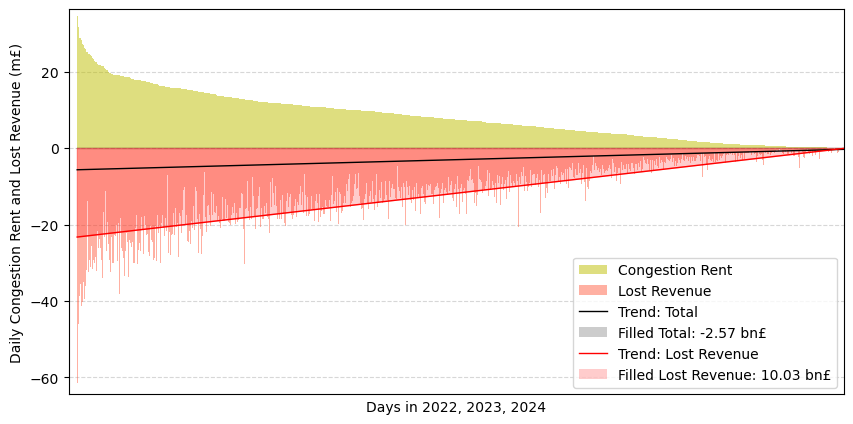

In [10]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x = np.arange(len(plo))

for i, (day, row) in enumerate(plo.iterrows()):
    ax.bar(i, width=1, bottom=0, height=row.congestion_rent, alpha=0.5, color='y')
    ax.bar(i, width=1, bottom=0, height=row.lost_revenue, alpha=0.5, color='tomato')

# Prepare data for linear regression using sklearn
X = x.reshape(-1, 1)
y_total = (plo['congestion_rent'] + plo['lost_revenue']).values
y_lost = plo['lost_revenue'].values

# Linear regression for total (congestion_rent + lost_revenue)
model_total = LinearRegression()
model_total.fit(X, y_total)
pred_total = model_total.predict(X)

# Linear regression for lost revenue
model_lost = LinearRegression()
model_lost.fit(X, y_lost)
pred_lost = model_lost.predict(X)

# Plot the regression lines
ax.plot(x, pred_total, color='k', linewidth=1)
ax.fill_between(x, np.clip(pred_total, 0, None), color='k', alpha=0.2)
ax.plot(x, pred_lost, color='r', linewidth=1)
ax.fill_between(x, np.minimum(pred_lost, 0), color='r', alpha=0.2)


ax.set_ylabel('Daily Congestion Rent and Lost Revenue (m£)')
ax.set_ylim(plo['lost_revenue'].min() * 1.05, plo['congestion_rent'].max() * 1.05)

ax.set_xticks([])
ax.set_xlabel('Days in 2022, 2023, 2024')


margin = 10
positive_idx = np.where(pred_lost > 0)[0][0]

#  if positive_idx.size > 0:
#   upper_limit = positive_idx[-1] + margin
# else:
#     upper_limit = len(plo) + margin

ax.set_xlim(-margin, positive_idx)

ax.grid(True, linestyle='--', alpha=0.5, axis='y')
ax.set_axisbelow(True)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

filled_total_bn = (plo['lost_revenue'] + plo['congestion_rent']).sum() / 1000.0
filled_lost_bn = abs(plo['lost_revenue'].sum()) / 1000.0

handles = [
    Patch(facecolor='y', alpha=0.5, label='Congestion Rent'),
    Patch(facecolor='tomato', alpha=0.5, label='Lost Revenue'),
    Line2D([0], [0], color='k', lw=1, label='Trend: Total'),
    Patch(facecolor='k', alpha=0.2, label=f'Filled Total: {filled_total_bn:.2f} bn£'),
    Line2D([0], [0], color='r', lw=1, label='Trend: Lost Revenue'),
    Patch(facecolor='r', alpha=0.2, label=f'Filled Lost Revenue: {filled_lost_bn:.2f} bn£')
]

ax.legend(handles=handles, loc='lower right')

def add_number(num, x, y):
    """
    Adds a text 'num' to the current plot at the position (x, y) with a circle around it.
    """
    ax = plt.gca()  # Get the current axes
    ax.text(
        x, y, str(num),
        ha='center', va='center',
        bbox=dict(
            boxstyle='circle',
            edgecolor='black',
            facecolor='w',
            linewidth=1
        )
    )

# add_number(1, 20, 1.7)
# add_number(2, 20, -5)
plt.savefig('cfd_versus_lost_revenue.pdf')
plt.show()

In [108]:
df.sort_values('roc_revenue')

,asset,asset_type,wholesale_revenue,cfd_revenue,roc_revenue
210,FDUNT-1,generator,0.000000,0.0,0.000000
282,SEEL-1,generator,6231.473732,0.0,0.000000
281,SEAB-2,generator,9425.525077,0.0,0.000000
280,SEAB-1,generator,87461.006020,0.0,0.000000
279,SCCL-3,generator,51489.827053,0.0,0.000000
...,...,...,...,...,...
173,WLNYW-1,generator,146135.687653,0.0,555342.292982
132,GYMRO-15,generator,148274.967435,0.0,561710.477526
170,WLNYO-2,generator,158223.956679,0.0,614004.665803
174,WTMSO-1,generator,186538.048462,0.0,722067.684259


In [109]:
df.iloc[:,-3:].sum().mul(1e-6)


wholesale_revenue    41.681976
cfd_revenue          12.703420
roc_revenue          24.712546
dtype: float64

In [110]:
import pypsa

n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_flex_s_national_solved.nc'
)


INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units


In [122]:
l = n.loads.index[n.loads.carrier == 'electricity']

n.loads_t.p_set.loc[:,l].sum(axis=1)

snapshot
2024-03-22 00:00:00    28524.916667
2024-03-22 00:30:00    28600.250000
2024-03-22 01:00:00    28196.283333
2024-03-22 01:30:00    28164.033333
2024-03-22 02:00:00    27093.000000
2024-03-22 02:30:00    27079.283333
2024-03-22 03:00:00    25802.633333
2024-03-22 03:30:00    25752.233333
2024-03-22 04:00:00    25784.300000
2024-03-22 04:30:00    25629.333333
2024-03-22 05:00:00    26904.166667
2024-03-22 05:30:00    26682.983333
2024-03-22 06:00:00    28647.600000
2024-03-22 06:30:00    29608.533333
2024-03-22 07:00:00    31435.466667
2024-03-22 07:30:00    31625.600000
2024-03-22 08:00:00    32033.083333
2024-03-22 08:30:00    32462.683333
2024-03-22 09:00:00    32239.066667
2024-03-22 09:30:00    31629.766667
2024-03-22 10:00:00    31113.566667
2024-03-22 10:30:00    30415.683333
2024-03-22 11:00:00    30290.483333
2024-03-22 11:30:00    30058.566667
2024-03-22 12:00:00    29703.433333
2024-03-22 12:30:00    29579.900000
2024-03-22 13:00:00    29274.283333
2024-03-22 13:30:00

In [129]:
df = pd.read_csv(Path.cwd().parent / 'results' / '2024-03-22' / 'bmu_revenues_detailed_flex_national.csv').set_index('asset')
print(df)

ss = ['wholesale_revenue', 'cfd_revenue', 'roc_revenue']

a = df[ss].stack().rename('2024-03-22')
b = df[ss].stack().rename('2024-03-23')

pd.concat((a,b), axis=1)

              asset_type  wholesale_revenue  cfd_revenue    roc_revenue
asset                                                                  
CMSTW-1        generator       47997.000325          0.0  122517.716488
ROTHW-1        generator       52579.775686          0.0  135504.568528
PAUHW-1        generator       67302.112878          0.0  167194.482759
CAIRW-2        generator       44013.724326          0.0   83562.076150
MDHLW-1        generator       58968.941679          0.0  118536.000000
...                  ...                ...          ...            ...
IFA2      interconnector      909485.356974          0.0       0.000000
Nemo      interconnector      240924.833514          0.0       0.000000
Viking    interconnector      256648.310997          0.0       0.000000
ElecLink  interconnector      549036.989181          0.0       0.000000
NSL       interconnector      261704.520027          0.0       0.000000

[422 rows x 4 columns]


2024-03-22     2024-03-23
asset                                                   
CMSTW-1  wholesale_revenue   47997.000325   47997.000325
         cfd_revenue             0.000000       0.000000
         roc_revenue        122517.716488  122517.716488
ROTHW-1  wholesale_revenue   52579.775686   52579.775686
         cfd_revenue             0.000000       0.000000
...                                   ...            ...
ElecLink cfd_revenue             0.000000       0.000000
         roc_revenue             0.000000       0.000000
NSL      wholesale_revenue  261704.520027  261704.520027
         cfd_revenue             0.000000       0.000000
         roc_revenue             0.000000       0.000000

[1266 rows x 2 columns]